***This project focused on classifying tweets into different categories using NLP techniques and a deep learning model (LSTMs). The dataset is preprocessed, tokenized, and trained using a neural network.***


### ***IMPORT NECESSARY LIBRARIES***

In [3]:
import pandas as pd
import numpy as np
import spacy
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE

### ***LOAD AND EXPLORE DATASET***

In [5]:
df = pd.read_csv("/content/labeled_data.csv")

In [6]:
# Check dataset shape (rows, columns)
print("Dataset Shape:", df.shape)

Dataset Shape: (24783, 7)


In [7]:
# Display first few rows
df.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [8]:
# Display column names
df.columns

Index(['Unnamed: 0', 'count', 'hate_speech', 'offensive_language', 'neither',
       'class', 'tweet'],
      dtype='object')

### ***DATA CLEANING AND PREPROCESSING***

In [9]:
df.drop(columns=['Unnamed: 0', 'count', 'hate_speech', 'offensive_language', 'neither'], inplace=True)

In [10]:
df.head()

,class,tweet
0,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [11]:
# Check for missing values
print("Missing Values:", df.isna().sum())

Missing Values: class    0
tweet    0
dtype: int64


In [12]:
# Display a few tweets to understand raw data
print("Sample Tweet 0:", df["tweet"].iloc[0])
print("Sample Tweet 100:", df["tweet"].iloc[100])
print("Sample Tweet 1000:", df["tweet"].iloc[1000])

Sample Tweet 0: !!! RT @mayasolovely: As a woman you shouldn't complain about cleaning up your house. &amp; as a man you should always take the trash out...
Sample Tweet 100: "@ClicquotSuave: LMAOOOOOOOOOOO this nigga @Krillz_Nuh_Care http://t.co/AAnpSUjmYI" &lt;bitch want likes for some depressing shit..foh
Sample Tweet 1000: &#128514;&#128514;&#128514;&#128514;&#128514;&#128514;&#128514;"@betysweetcocker: That pussy is just....&#128561; imma assume she just had a baby like..the day before"


### ***TEXT PREPROCESSING***

In [13]:
# Removed non-alphabetic characters (punctuation, numbers, special symbols)
df["processed_tweet"] = df["tweet"].str.replace(r"[^a-zA-Z]", " ", regex=True)

# Removed extra spaces
df["processed_tweet"] = df["processed_tweet"].str.replace(r"[\s]+", " ", regex=True)

In [14]:
# Drop the original tweet column after preprocessing
df.drop(columns=["tweet"], inplace=True)

In [15]:
df.head()

,class,processed_tweet
0,2,RT mayasolovely As a woman you shouldn t comp...
1,1,RT mleew boy dats cold tyga dwn bad for cuffi...
2,1,RT UrKindOfBrand Dawg RT sbaby life You ever ...
3,1,RT C G Anderson viva based she look like a tr...
4,1,RT ShenikaRoberts The shit you hear about me ...


### ***TEXT NORMALIZATION (LEMMATIZATION & STOPWORD REMOVAL)***

In [16]:
# Load spaCy English language model
nlp = spacy.load("en_core_web_sm")

In [19]:
def lemmatization(text):
    doc = nlp(text)
    return " ".join([word.lemma_ for word in doc])

df["Lemma_tweet"] = df["processed_tweet"].apply(lemmatization)

***Remove stopwords***

In [20]:
def remove_stopword(text):
    doc = nlp(text)
    return " ".join([word.text for word in doc if not word.is_stop])

df["final_tweet"] = df["Lemma_tweet"].apply(remove_stopword)

### ***TEXT TOKENIZATION***

*Convert text into numerical representation using one-hot encoding*

In [21]:
vocab_size = 10000
one_hot_representation = [one_hot(words, vocab_size) for words in df["final_tweet"]]

In [22]:
# Display some tokenized representations
for i in range(4):
    print(f"Original Tweet: {df['final_tweet'].iloc[i]}")
    print(f"Tokenized: {one_hot_representation[i]}")

Original Tweet:    RT mayasolovely woman shouldn t complain clean house amp man trash
Tokenized: [4388, 9875, 7882, 9035, 4005, 6303, 561, 6339, 8842, 3658, 9309]
Original Tweet:    RT mleew boy dat cold tyga dwn bad cuffin dat hoe st place
Tokenized: [4388, 7099, 8952, 1045, 7677, 8826, 4935, 3905, 9859, 1045, 6816, 8973, 9328]
Original Tweet:    RT UrKindOfBrand Dawg RT sbaby life fuck bitch start cry confuse shit
Tokenized: [4388, 516, 4492, 4388, 8490, 7177, 5007, 9011, 8445, 1005, 5200, 6244]
Original Tweet:    RT C G Anderson viva base look like tranny
Tokenized: [4388, 1357, 5416, 1372, 8806, 3304, 44, 5808, 966]


**PAD SEQUENCES TO ENSURE UNIFORM LENGTH**

In [23]:
sentence_length = 20
embedded_tweet = pad_sequences(one_hot_representation, padding="pre", maxlen=sentence_length)


In [25]:
# convert to numpy array for model training
X = np.array(embedded_tweet)
y = np.array(df["class"])

**CHECK CLASS DISTRIBUTION**

In [26]:
print("Class Distribution:\n", df["class"].value_counts())

Class Distribution:
 class
1    19190
2     4163
0     1430
Name: count, dtype: int64


***HANDLING CLASS IMBALANCE USING SMOTE***

In [27]:
smote = SMOTE(sampling_strategy="minority")
X, y = smote.fit_resample(X, y)

***SPLIT DATA INTO TRAINING AND TESTING SETS***

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training Data Shape: {X_train.shape}, Testing Data Shape: {X_test.shape}")

Training Data Shape: (34034, 20), Testing Data Shape: (8509, 20)


### ***BUILDING LSTM MODEL***

In [29]:
dimension = 50

model = keras.Sequential([
    keras.layers.Embedding(vocab_size, dimension, input_length=sentence_length),
    keras.layers.LSTM(100, return_sequences=True),
    keras.layers.LSTM(50, return_sequences=True),
    keras.layers.LSTM(50),
    keras.layers.Dense(3, activation="softmax")
])

# Compile the model
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

# Build the model input shape
model.build(input_shape=(None, sentence_length))

# Display model architecture
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 20, 50)              │         500,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 20, 100)             │          60,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 20, 50)              │          30,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 3)                   │             153 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 610,953 (2.33 MB)

 Trainable params: 610,953 (2.33 MB)

 Non-trainable params: 0 (0.00 B)

In [30]:
# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10
1064/1064 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step - accuracy: 0.7678 - loss: 0.5184 - val_accuracy: 0.9233 - val_loss: 0.2354
Epoch 2/10
1064/1064 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - accuracy: 0.9464 - loss: 0.1615 - val_accuracy: 0.9221 - val_loss: 0.2362
Epoch 3/10
1064/1064 ━━━━━━━━━━━━━━━━━━━━ 24s 13ms/step - accuracy: 0.9643 - loss: 0.1183 - val_accuracy: 0.9106 - val_loss: 0.2959
Epoch 4/10
1064/1064 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - accuracy: 0.9735 - loss: 0.0880 - val_accuracy: 0.9067 - val_loss: 0.3721
Epoch 5/10
1064/1064 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - accuracy: 0.9810 - loss: 0.0679 - val_accuracy: 0.9042 - val_loss: 0.4115
Epoch 6/10
1064/1064 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.9840 - loss: 0.0533 - val_accuracy: 0.8960 - val_loss: 0.4226
Epoch 7/10
1064/1064 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.9878 - loss: 0.0374 - val_accuracy: 0.8985 - val_loss: 0.5099
Epoch 8/10
1064/1064 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.9913 - los

***MODEL EVALUATION***

In [31]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Model Accuracy: {accuracy * 100:.2f}%")

266/266 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8964 - loss: 0.6157
Model Accuracy: 89.15%


***MODEL PREDICTIONS***

In [32]:
pred = np.argmax(model.predict(X_test), axis=-1)

# Display actual vs predicted labels for the first 5 samples
print("Actual Labels:", y_test[:5])
print("Predicted Labels:", pred[:5])

266/266 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
Actual Labels: [1 1 0 1 2]
Predicted Labels: [1 1 0 1 2]


***PERFORMANCE ANALYSIS***

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.91      0.91      3812
           1       0.91      0.91      0.91      3807
           2       0.73      0.74      0.73       890

    accuracy                           0.89      8509
   macro avg       0.85      0.85      0.85      8509
weighted avg       0.89      0.89      0.89      8509



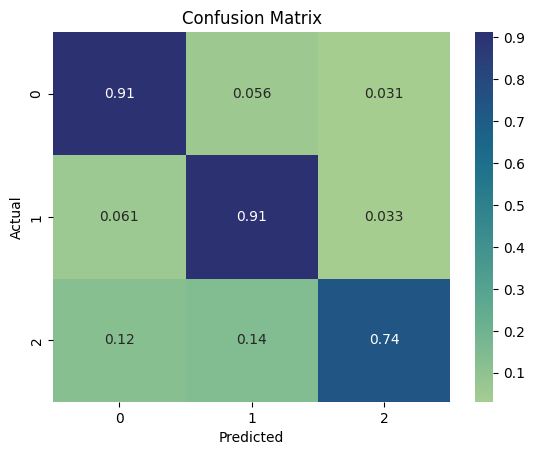

In [33]:
print("Classification Report:\n", classification_report(y_test, pred))

# Confusion matrix distribution

cf_matrix = confusion_matrix(y_test, pred, normalize="true")
sns.heatmap(cf_matrix, annot=True, cmap="crest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()